# Data Querying and Exporting

This notebook demonstrates the process of querying data from Delta Lake and exporting it in various formats.

## Starting the servers:
To launch the server, open the Docker Desktop app and run the following command at the root of the project:
```bash
$ make up
```
This command will launch the Django server, Postgres database, and Jupyter server using the environment variables defined in the `.env` file accross all containers.

#### Understanding expected file paths:
DiveDB expects the following paths to be set in the `.env` file:
- `CONTAINER_DATA_PATH`
- `LOCAL_DATA_PATH`
- `HOST_DELTA_LAKE_PATH`
- `CONTAINER_DELTA_LAKE_PATH`
- `HOST_FILE_STORAGE_PATH`
- `CONTAINER_FILE_STORAGE_PATH`

These paths are used to mount the Delta Lake and file storage to the containers. The "LOCAL_" and "HOST_" paths can be wherever makes sense for your local machine. The "CONTAINER_" paths are the paths that the containers expect. We recommend you keep the "CONTAINER_" paths as they are in the `.env.example` file.

#### When is the server ready?
There are 3 processes that need to be running for the server to be ready:
1. The Django server (`web`)
2. The Postgres database (`metadata_database`)
3. The Jupyter server (`jupyter`)

Jupyter is almost always the last to start up. You'll know it's ready when you see the following logs in the terminal:
```bash
jupyter-1            | [I 2024-08-30 16:12:37.083 ServerApp] Serving notebooks from local directory: /app
jupyter-1            | [I 2024-08-30 16:12:37.083 ServerApp] Jupyter Server 2.14.2 is running at:
jupyter-1            | [I 2024-08-30 16:12:37.083 ServerApp] http://e29d05e13fd0:8888/jupyter/tree
jupyter-1            | [I 2024-08-30 16:12:37.083 ServerApp]     http://127.0.0.1:8888/jupyter/tree
```

## Connecting to the Jupyter Kernel:
To connect to the Jupyter server in your notebook, follow these steps:
1. Click the "Select Kernel" button at the top right of the page.
1. Pick the "Select another kernel" option in the dropdown menu.
1. Pick the "Existing Jupyter Server" option in the dropdown menu.
1. Now we need to connect to the Jupyter server.
    - If you previously connected to the Jupyter server
        - Pick the "localhost" option in the dropdown menu (or whatever you named it prior)
    - If you have not connected to the Jupyter server before
        - Pick the "Enter the URL of the running Jupyter server" option in the dropdown menu.
        - Enter http://localhost:8888/jupyter
        - Give it a name you'll remember (like "Local DiveDB Jupyter Server")
1. Press the "Reload" icon in the top right of the dropdown menu to see the latest kernel.
1. Pick the "Python 3" option in the dropdown menu.

This will ensure you execute the Jupyter notebook in the correct environment.

## Querying from Delta Lake
We connect to our datastores using the `DuckPond` class. DuckPond is a wrapper around a DuckDB connection with access to both our Metadata Database and our measurements stored in Delta Lake. The ability to query both sources of data from a single connection is useful for quickly accessing data for analysis.

There are two main ways to query data from Delta Lake:
1. Using the DuckPond `get_delta_data` method
2. Using the DuckPond connection to query directly

### Using the DuckPond `get_delta_data` method
DuckPond's `get_delta_data` method constructs a query based on the parameters you pass to it and returns a DuckDB DataFrame. It is useful for quickly accessing data for analysis. It takes the following optional parameters:
- `labels`: A string or list of data labels to query.
- `logger_ids`: A string or list of logger IDs to query.
- `animal_ids`: A string or list of animal IDs to query.
- `deployment_ids`: A string or list of deployment IDs to query.
- `recording_ids`: A string or list of recording IDs to query.
- `date_range`: A tuple of start and end dates to query.
- `limit`: The maximum number of rows to return.

The `get_delta_data` method returns a [DuckDB DuckDBPyConnection](https://duckdb.org/docs/api/python/reference/#duckdb.DuckDBPyConnection) which can be used to convert the data in many different formats including the following ([see documentation for a full list](https://duckdb.org/docs/api/python/conversion#result-conversion-duckdb-results-to-python))
- NumPy Array (`.fetchnumpy()`)
- Pandas DataFrame (`.df()`)
- Arrows Table (`.arrow()`)
- Polars DataFrame (`.pl()`)

Until a conversion method is called, the data is not loaded into memory. This allows for large queries to be run without using too much memory.

##### Example:

In [3]:
import importlib
import DiveDB.services.duck_pond
import DiveDB.services.utils.edf
importlib.reload(DiveDB.services.duck_pond)
importlib.reload(DiveDB.services.utils.edf)

from DiveDB.services.duck_pond import DuckPond
from DiveDB.services.utils.edf import create_mne_array, create_mne_edf

duckpond = DuckPond()

conn = duckpond.get_delta_data(    
    labels=["depth"],
)

display(conn)

IO Error: Hit DeltaKernel FFI error (from: While trying to read from delta table: 's3://divedb-delta-lakes/point_events/'): Hit error: 15 (MissingVersionError) with message (No table version found.)
IO Error: Hit DeltaKernel FFI error (from: While trying to read from delta table: 's3://divedb-delta-lakes/state_events/'): Hit error: 15 (MissingVersionError) with message (No table version found.)


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌──────────────────────────┬────────┐
│         datetime         │ depth  │
│ timestamp with time zone │ double │
├──────────────────────────┼────────┤
│ 2004-02-16 23:52:00+00   │  -40.0 │
│ 2004-02-16 23:52:04+00   │  -40.0 │
│ 2004-02-16 23:52:08+00   │  -40.0 │
│ 2004-02-16 23:52:12+00   │  -40.0 │
│ 2004-02-16 23:52:16+00   │  -40.0 │
│ 2004-02-16 23:52:20+00   │  -40.0 │
│ 2004-02-16 23:52:24+00   │  -40.0 │
│ 2004-02-16 23:52:28+00   │  -40.0 │
│ 2004-02-16 23:52:32+00   │  -40.0 │
│ 2004-02-16 23:52:36+00   │  -40.0 │
│           ·              │    ·   │
│           ·              │    ·   │
│           ·              │    ·   │
│ 2004-02-17 10:58:00+00   │  -40.0 │
│ 2004-02-17 10:58:04+00   │  -40.0 │
│ 2004-02-17 10:58:08+00   │  -40.0 │
│ 2004-02-17 10:58:12+00   │  -40.0 │
│ 2004-02-17 10:58:16+00   │  -40.0 │
│ 2004-02-17 10:58:20+00   │  -40.0 │
│ 2004-02-17 10:58:24+00   │  -40.0 │
│ 2004-02-17 10:58:28+00   │  -40.0 │
│ 2004-02-17 10:58:32+00   │  -40.0 │
│ 2004-02-17

## Querying for shared frequency from Delta Lake
Delta Lake can store multiple signal names at a single frequency. If you query a single signal name, the data will be returned as a list of values for each timestamp. If you query multiple signal names, the data will be returned as a list of lists of values for each timestamp.

The data will be returned as a Pandas DataFrame with a DatetimeIndex.

##### Example:

In [ ]:
import importlib
import DiveDB.services.duck_pond
import DiveDB.services.utils.edf
importlib.reload(DiveDB.services.duck_pond)
importlib.reload(DiveDB.services.utils.edf)

from DiveDB.services.duck_pond import DuckPond
from DiveDB.services.utils.edf import create_mne_array, create_mne_edf

duckpond = DuckPond()

duckpond.get_delta_data(    
    labels=["corr_depth"],
    animal_ids="oror-002",
    # Once a minute
    # frequency=1/60,
)


In [ ]:
import importlib
import DiveDB.services.duck_pond
import DiveDB.services.utils.edf
importlib.reload(DiveDB.services.duck_pond)
importlib.reload(DiveDB.services.utils.edf)

from DiveDB.services.duck_pond import DuckPond
from DiveDB.services.utils.edf import create_mne_array, create_mne_edf

duckpond = DuckPond()

df = duckpond.conn.sql(    
    """
    SELECT animal, day, label, min(value) as minval, max(value) as maxval, mean(value) as meanval
    FROM
        (
            SELECT 
                animal, 
                date_trunc('day', datetime) as day, 
                value.float as value,
                label
            FROM DataLake 
            WHERE 
                label IN ('lat', 'lon', 'corr_depth')
        )
    GROUP BY animal, day, label
    """
).df()

df


IO Error: Hit DeltaKernel FFI error (from: While trying to read from delta table: 's3://divedb-delta-lakes/point_events/'): Hit error: 15 (MissingVersionError) with message (No table version found.)
IO Error: Hit DeltaKernel FFI error (from: While trying to read from delta table: 's3://divedb-delta-lakes/state_events/'): Hit error: 15 (MissingVersionError) with message (No table version found.)


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,animal,day,label,minval,maxval,meanval
0,M141,2004-05-29 00:00:00+00:00,lon,-122.330756,-122.330756,-122.330756
1,M141,2004-06-05 00:00:00+00:00,lon,-128.393000,-127.873000,-128.112000
2,M141,2004-06-09 00:00:00+00:00,lon,-131.624000,-130.994000,-131.208200
3,M141,2004-06-24 00:00:00+00:00,lon,-144.001000,-143.963000,-143.982000
4,M141,2004-06-26 00:00:00+00:00,lon,-145.946000,-145.478000,-145.637000
...,...,...,...,...,...,...
5814,99AB,2004-03-10 00:00:00+00:00,corr_depth,NaN,NaN,NaN
5815,99AB,2004-03-12 00:00:00+00:00,corr_depth,NaN,NaN,NaN
5816,99AB,2004-03-13 00:00:00+00:00,corr_depth,NaN,NaN,NaN
5817,99AB,2004-03-21 00:00:00+00:00,corr_depth,NaN,NaN,NaN


In [21]:
import pandas as pd
df2 = pd.merge(
    pd.merge(
        df[df['label'] == 'lat'].rename(columns={'minval': 'min_lat', 'maxval': 'max_lat'}).drop(columns=["label"]),
        df[df['label'] == 'lon'].rename(columns={'minval': 'min_lon', 'maxval': 'max_lon'}).drop(columns=["label"]),
        on=['animal', 'day'],
        suffixes=('_lat', '_lon')
    ),
    df[df['label'] == 'corr_depth'].rename(columns={'minval': 'min_depth', 'maxval': 'max_depth'}).drop(columns=["label"]),
    on=['animal', 'day'],
    suffixes=('', '_depth')
)

df2

,animal,day,min_lat,max_lat,min_lon,max_lon,min_depth,max_depth
0,L563,2004-06-08 00:00:00+00:00,41.866,42.354,-128.685,-128.247,0.0,655.5
1,L563,2004-06-12 00:00:00+00:00,43.945,44.299,-129.904,-129.681,0.0,790.0
2,L563,2004-06-15 00:00:00+00:00,44.915,45.529,-131.082,-129.299,0.0,664.0
3,L563,2004-06-20 00:00:00+00:00,45.153,45.637,-132.512,-131.661,0.0,663.0
4,L563,2004-07-04 00:00:00+00:00,45.953,46.127,-133.205,-132.664,0.0,747.0
...,...,...,...,...,...,...,...,...
1722,O448,2004-08-30 00:00:00+00:00,42.065,42.065,-143.914,-143.914,0.0,687.0
1723,O448,2004-10-07 00:00:00+00:00,44.660,44.660,-143.657,-143.657,0.0,1120.0
1724,O448,2004-11-07 00:00:00+00:00,45.393,45.393,-138.022,-138.022,0.0,792.0
1725,O448,2004-11-19 00:00:00+00:00,43.323,43.345,-131.629,-131.610,0.0,812.5


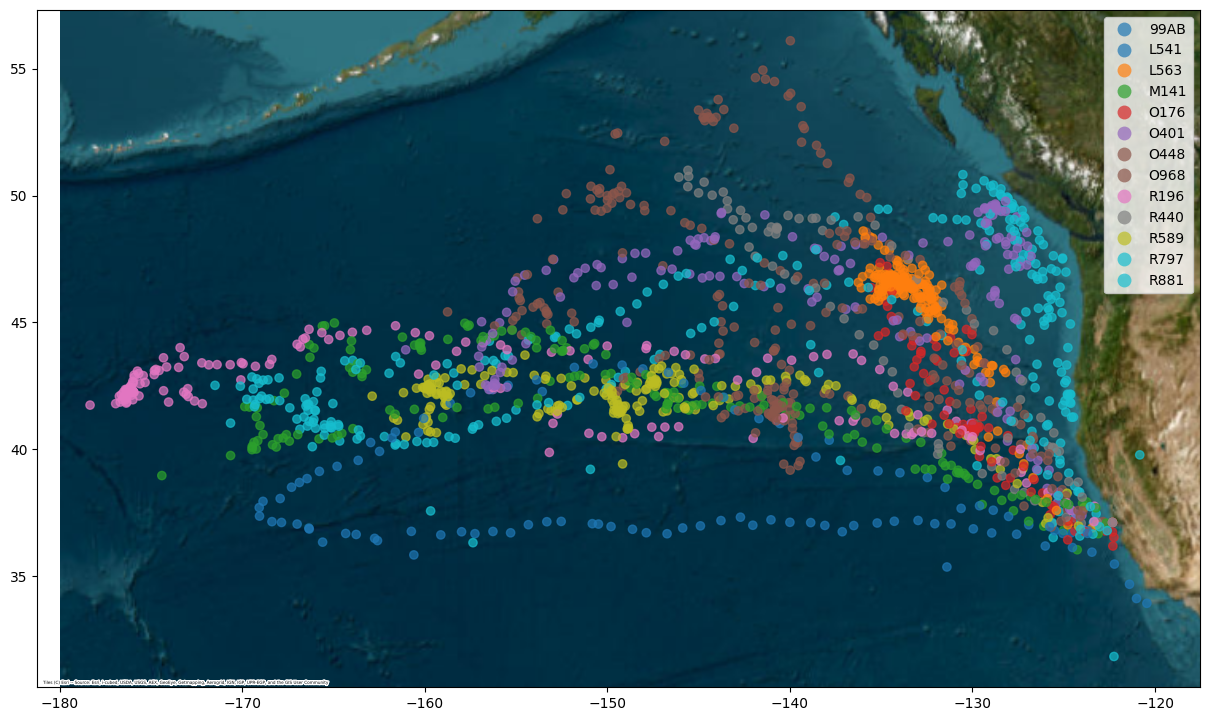

In [83]:
import geopandas as gpd
import contextily as ctx

gdf = gpd.GeoDataFrame(
    df2.reset_index(),
    geometry=gpd.points_from_xy(df2.reset_index().min_lon, df2.reset_index().min_lat),
    crs="EPSG:4326"
)

gdf = gdf[gdf.min_lon < -120]

ax = gdf.plot(column="animal", figsize=(15, 15), legend=True, alpha=0.7)
ctx.add_basemap(ax, crs=gdf.crs.to_string(), source=ctx.providers.Esri.WorldImagery, attribution_size=3, zoom=4)


,index,animal,day,min_lat,max_lat,min_lon,max_lon,min_depth,max_depth,geometry
0,0,L563,2004-06-08 00:00:00+00:00,41.866,42.354,-128.685,-128.247,0.0,655.5,POINT (-129 41)
1,1,L563,2004-06-12 00:00:00+00:00,43.945,44.299,-129.904,-129.681,0.0,790.0,POINT (-130 43)
2,2,L563,2004-06-15 00:00:00+00:00,44.915,45.529,-131.082,-129.299,0.0,664.0,POINT (-132 44)
3,3,L563,2004-06-20 00:00:00+00:00,45.153,45.637,-132.512,-131.661,0.0,663.0,POINT (-133 45)
4,4,L563,2004-07-04 00:00:00+00:00,45.953,46.127,-133.205,-132.664,0.0,747.0,POINT (-134 45)
...,...,...,...,...,...,...,...,...,...,...
1722,1722,O448,2004-08-30 00:00:00+00:00,42.065,42.065,-143.914,-143.914,0.0,687.0,POINT (-144 42)
1723,1723,O448,2004-10-07 00:00:00+00:00,44.660,44.660,-143.657,-143.657,0.0,1120.0,POINT (-144 44)
1724,1724,O448,2004-11-07 00:00:00+00:00,45.393,45.393,-138.022,-138.022,0.0,792.0,POINT (-139 45)
1725,1725,O448,2004-11-19 00:00:00+00:00,43.323,43.345,-131.629,-131.610,0.0,812.5,POINT (-132 43)


,animal,geometry,count
0,L563,POINT (-135 46),48
1,L563,POINT (-134 46),35
2,R589,POINT (-160 42),22
3,O448,POINT (-141 41),21
4,L563,POINT (-133 46),19
...,...,...,...
838,99AB,POINT (-157 42),0
839,99AB,POINT (-156 42),0
840,99AB,POINT (-154 42),0
841,99AB,POINT (-152 43),0


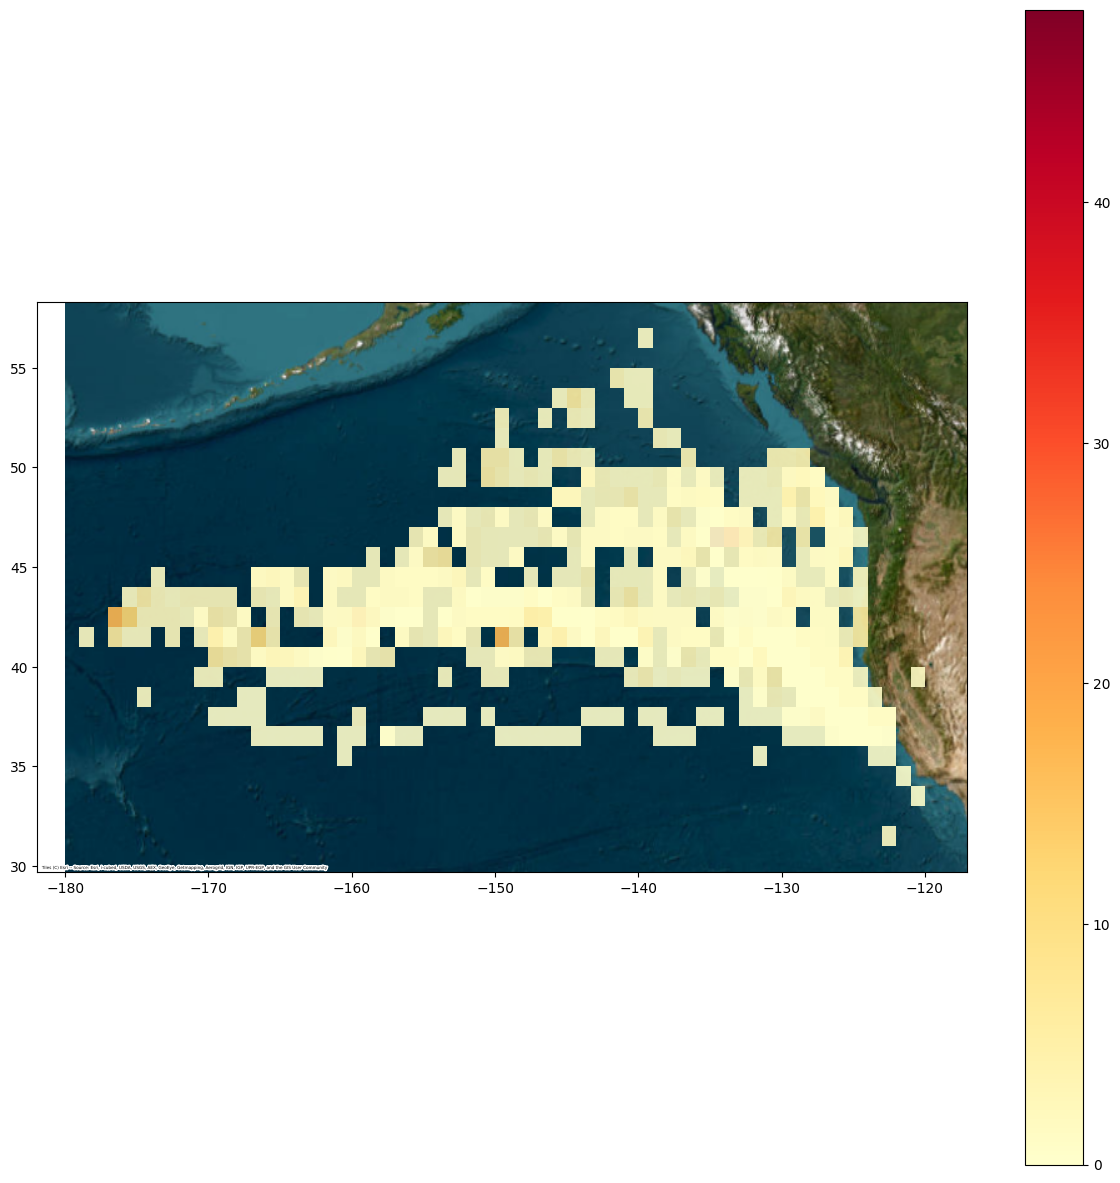

In [76]:
import math
from shapely.geometry import Polygon

FACTOR = 1

gdf = gpd.GeoDataFrame(
    df2.reset_index(),
    geometry=gpd.points_from_xy(df2.reset_index().min_lon.apply(lambda x: math.floor(x * FACTOR) / FACTOR), df2.reset_index().min_lat.apply(lambda x: math.floor(x * FACTOR) / FACTOR)),
    crs="EPSG:4326"
)

gdf = gdf[gdf.min_lon < -120]


display(gdf)

gdf2 = gdf[["geometry", "max_depth"]].groupby(["geometry"]).count().rename(columns={"max_depth": "count"}).sort_values(by="count", ascending=False).reset_index()
display(gdf2)

gdf2.geometry = gdf2.geometry.apply(lambda pt: Polygon([(pt.x, pt.y), (pt.x+1/FACTOR, pt.y), (pt.x+1/FACTOR, pt.y+1/FACTOR), (pt.x, pt.y+1/FACTOR)]))

gdf = gpd.GeoDataFrame(
    gdf2.reset_index(),
    geometry=gdf2.geometry,
    crs="EPSG:4326"
)


ax = gdf.plot(column="count", cmap="YlOrRd", figsize=(15, 15), legend=True, alpha=0.9)
ctx.add_basemap(ax, crs=gdf.crs.to_string(), source=ctx.providers.Esri.WorldImagery, attribution_size=3, zoom=4)


,index,animal,day,min_lat,max_lat,min_lon,max_lon,min_depth,max_depth,geometry
0,0,L563,2004-06-08 00:00:00+00:00,41.866,42.354,-128.685,-128.247,0.0,655.5,POINT (-129 41)
1,1,L563,2004-06-12 00:00:00+00:00,43.945,44.299,-129.904,-129.681,0.0,790.0,POINT (-130 43)
2,2,L563,2004-06-15 00:00:00+00:00,44.915,45.529,-131.082,-129.299,0.0,664.0,POINT (-132 44)
3,3,L563,2004-06-20 00:00:00+00:00,45.153,45.637,-132.512,-131.661,0.0,663.0,POINT (-133 45)
4,4,L563,2004-07-04 00:00:00+00:00,45.953,46.127,-133.205,-132.664,0.0,747.0,POINT (-134 45)
...,...,...,...,...,...,...,...,...,...,...
1722,1722,O448,2004-08-30 00:00:00+00:00,42.065,42.065,-143.914,-143.914,0.0,687.0,POINT (-144 42)
1723,1723,O448,2004-10-07 00:00:00+00:00,44.660,44.660,-143.657,-143.657,0.0,1120.0,POINT (-144 44)
1724,1724,O448,2004-11-07 00:00:00+00:00,45.393,45.393,-138.022,-138.022,0.0,792.0,POINT (-139 45)
1725,1725,O448,2004-11-19 00:00:00+00:00,43.323,43.345,-131.629,-131.610,0.0,812.5,POINT (-132 43)


,geometry,count
0,POINT (-125 37),9
1,POINT (-126 37),8
2,POINT (-124 36),7
3,POINT (-125 36),7
4,POINT (-123 37),6
...,...,...
462,POINT (-140 44),1
463,POINT (-141 45),1
464,POINT (-142 44),1
465,POINT (-141 44),1


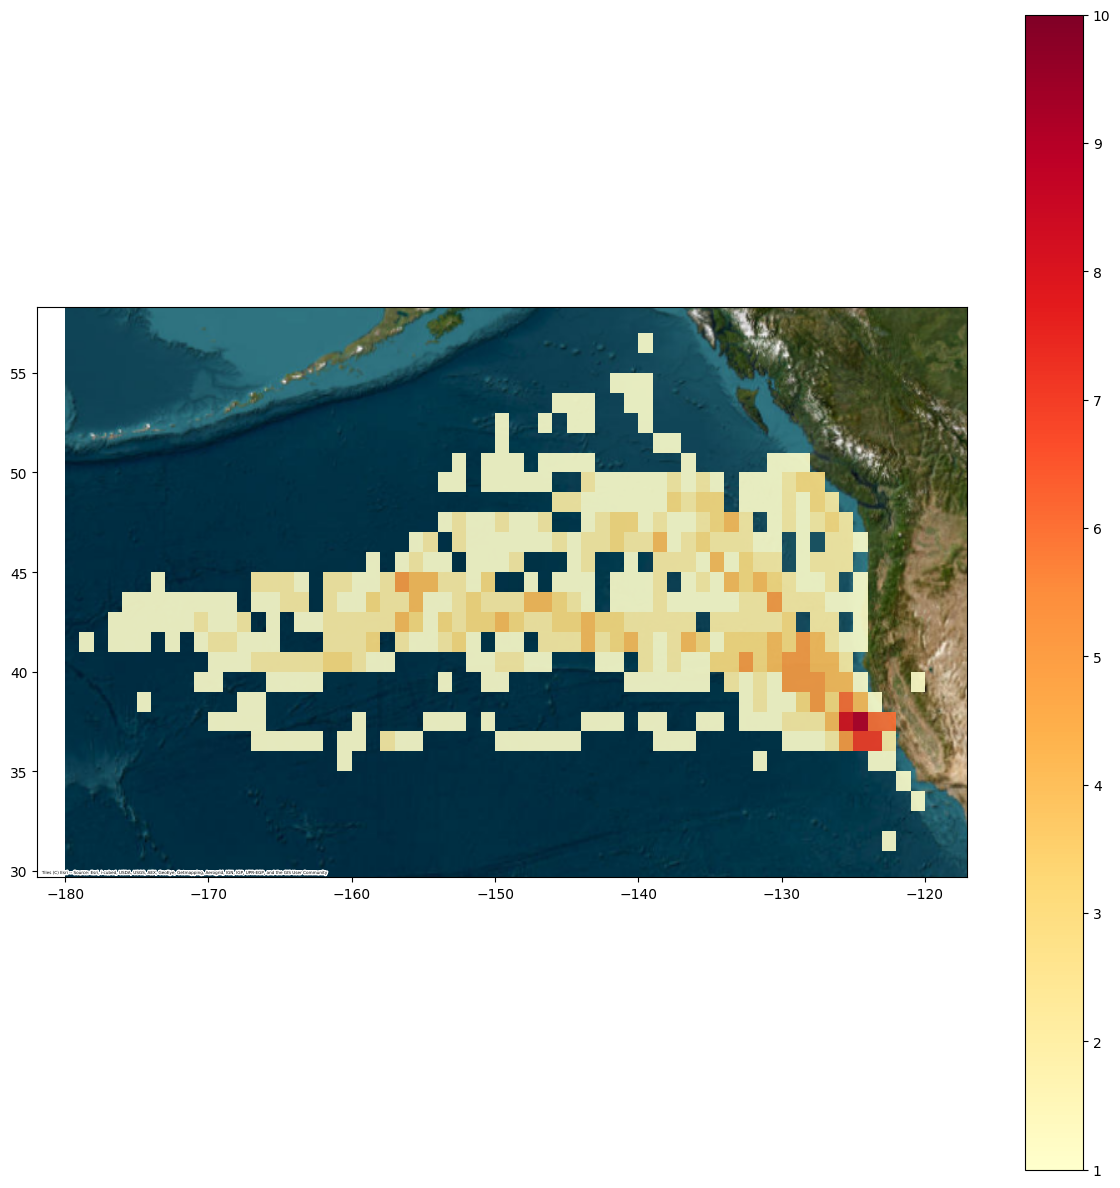

In [81]:
import math
from shapely.geometry import Polygon

FACTOR = 1

gdf = gpd.GeoDataFrame(
    df2.reset_index(),
    geometry=gpd.points_from_xy(df2.reset_index().min_lon.apply(lambda x: math.floor(x * FACTOR) / FACTOR), df2.reset_index().min_lat.apply(lambda x: math.floor(x * FACTOR) / FACTOR)),
    crs="EPSG:4326"
)

gdf = gdf[gdf.min_lon < -120]


display(gdf)

gdf2 = gdf[["animal", "geometry"]].groupby(["geometry"]).agg({"animal": "nunique"}).rename(columns={"animal": "count"}).sort_values(by="count", ascending=False).reset_index()

display(gdf2)

gdf2.geometry = gdf2.geometry.apply(lambda pt: Polygon([(pt.x, pt.y), (pt.x+1/FACTOR, pt.y), (pt.x+1/FACTOR, pt.y+1/FACTOR), (pt.x, pt.y+1/FACTOR)]))

gdf = gpd.GeoDataFrame(
    gdf2.reset_index(),
    geometry=gdf2.geometry,
    crs="EPSG:4326"
)


ax = gdf.plot(column="count", cmap="YlOrRd", vmax=10, figsize=(15, 15), legend=True, alpha=0.9)
ctx.add_basemap(ax, crs=gdf.crs.to_string(), source=ctx.providers.Esri.WorldImagery, attribution_size=3, zoom=4)


### Using the DuckPond connection to query directly
More complex queries can be run directly on the DuckPond connection. This is useful for queries that may not be supported by the `get_delta_data` method which has those involving grouping or aggregations. 

DuckDB runs sql very similar in syntax to other SQL databases. A full breakdown of the syntax can be found [in the documenation](https://duckdb.org/docs/sql/introduction).

The connection object can be found in the `duckpond.conn` attribute. To run queries, use the `sql` method which also returns a [DuckDB DuckDBPyConnection](https://duckdb.org/docs/api/python/reference/#duckdb.DuckDBPyConnection) which can be used to convert the data in many different formats including the following ([see documentation for a full list](https://duckdb.org/docs/api/python/conversion#result-conversion-duckdb-results-to-python))
- NumPy Array (`.fetchnumpy()`)
- Pandas DataFrame (`.df()`)
- Arrows Table (`.arrow()`)
- Polars DataFrame (`.pl()`)

##### Example:

In [ ]:
import importlib

# Reload the DuckPond module to pick up any changes
import DiveDB.services.duck_pond
importlib.reload(DiveDB.services.duck_pond)
from DiveDB.services.duck_pond import DuckPond

duckpond = DuckPond()

df = duckpond.conn.sql(f"""
SELECT label, avg(value) as mean_data
FROM (
    SELECT label, value.int as value
    FROM DataLake
    WHERE label = 'sensor_data_ecg'
    OR label = 'sensor_data_light'
)
GROUP BY label
""").df()

display(df)


## Chaining Queries
Queries can be chained together to form a pipeline. This is useful for running complex queries that involve multiple steps.

##### Example:

In [ ]:
import importlib

# Reload the DuckPond module to pick up any changes
import DiveDB.services.duck_pond
importlib.reload(DiveDB.services.duck_pond)
from DiveDB.services.duck_pond import DuckPond

duckpond = DuckPond()

# Get the filtered data
filtered_data = duckpond.get_delta_data(    
    animal_ids="oror-002",
    frequency=10, # Resample values to 10 Hz and make sure each signal has the same time intervals
    # Aggregation of events (think state events - behaviors) type: state (has state and end dates)
    classes="sensor_data_accelerometer",
    
)

display(filtered_data)


## Query Variables
Sometimes we don't want to hardcode variables in our queries. We can use the `execute` method to pass variables to the query.

##### Example:

In [ ]:
import importlib

# Reload the DuckPond module to pick up any changes
import DiveDB.services.duck_pond
importlib.reload(DiveDB.services.duck_pond)
from DiveDB.services.duck_pond import DuckPond

duckpond = DuckPond()

label = "sensor_data_temperature"
df = duckpond.conn.execute(f"""
SELECT label, avg(value) as mean_data
FROM (
    SELECT label, value.float as value
    FROM DataLake
    WHERE label = $1
)
GROUP BY label
""", [label]).df()
display(df)

## Query Metadata Database
We can also query the Metadata Database directly. This is useful for querying data that is not stored in Delta Lake and joining it for queries on measurement data.

##### Example:

In [ ]:
import importlib

# Reload the DuckPond module to pick up any changes
import DiveDB.services.duck_pond
importlib.reload(DiveDB.services.duck_pond)
from DiveDB.services.duck_pond import DuckPond

duckpond = DuckPond()


# Show all tables we have access to
print(duckpond.get_db_schema())

df = duckpond.conn.sql("""
SELECT value.float as value
FROM DataLake 
JOIN Metadata.public.Animals ON DataLake.animal = Animals.id
WHERE Animals.project_id = 'test12_Wednesday'
AND label = 'sensor_data_temperature'
""").df()


display(df)

## Exporting Data to EDF
When it's easier to work with EDF files, we can export the data to an EDF file. This is useful for working with the data in other software packages.

The `create_mne_edf` function takes a DuckDB connection and a file path and creates an EDF file. 

*Note: it currently requires a lot of memory. Can be improved.*
*Note: it's lacking support for most info fields in the EDF file. Can be improved.*

##### Example:

In [ ]:
import os
import importlib
import DiveDB.services.duck_pond
import DiveDB.services.utils.edf
importlib.reload(DiveDB.services.duck_pond)
importlib.reload(DiveDB.services.utils.edf)

from DiveDB.services.duck_pond import DuckPond
from DiveDB.services.utils.edf import create_mne_edf

duckpond = DuckPond()

conn = duckpond.get_delta_data(    
    animal_ids="mian-003",
    labels=["ECG_ICA2", "EEG_ICA5"],
    limit=1000000,
)

create_mne_edf(conn, "test.edf")

## Exporting Data to MNE Signal Array
For working with the data in MNE, we can export the data to an MNE Signal Array. This is useful for manipulating the data in MNE.

The `create_mne_array` function takes a DuckDB connection and returns an MNE RawArray.

##### Example:

In [ ]:
import importlib
import DiveDB.services.duck_pond
importlib.reload(DiveDB.services.duck_pond)
from DiveDB.services.duck_pond import DuckPond
from DiveDB.services.utils.edf import create_mne_array

duckpond = DuckPond()

conn = duckpond.get_delta_data(    
    animal_ids="mian-003",
    labels="ECG_ICA2",
    limit=1000000,
)

raw = create_mne_array(conn, resample=100, l_freq=1, h_freq=20)
display(raw)